In [1]:
import pandas as pd
from gemmi import cif
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


# parser
def cif_info_parser(file_name_i):
    doc = cif.read_file(file_name_i)
    block = doc.sole_block()
    helices = block.find_loop('_struct_conf')
    beg = list(block.find_values('_struct_conf.beg_auth_seq_id'))
    end = list(block.find_values('_struct_conf.end_auth_seq_id'))
    helices_dict = {'beg': beg, 'end': end}
    helices_pd = pd.DataFrame(data=helices_dict)
    
    sheets = block.find_loop('_struct_sheet_range')
    beg = list(block.find_values('_struct_sheet_range.beg_auth_seq_id'))
    end = list(block.find_values('_struct_sheet_range.end_auth_seq_id'))
    sheets_dict = {'beg': beg, 'end': end}
    sheets_pd = pd.DataFrame(data=sheets_dict)
    #print(helices_pd)
    #print(sheets_pd)
    return helices_pd, sheets_pd
    
    
def validation_parser(file_name_v):
    if file_name_v.endswith('xml'):
        with open(file_name_v, 'r') as f:
            data = f.read()

        Bs_data = BeautifulSoup(data, "xml")


        residues = Bs_data.find_all('ModelledSubgroup', {'ent': '1'})
        first = int(residues[0].get('resnum'))
        last = int(residues[-1].get('resnum'))
        seq_length = last-first

        ramachandran_list = []
        rotamer_list = []
        clash_list = []
        outliers = Bs_data.find_all('ModelledSubgroup')

        for i in outliers:
            if i.get('rota') == 'OUTLIER':
                rotamer_list.append(i.get('resnum'))
            if i.get('rama') == 'OUTLIER':
                ramachandran_list.append(i.get('resnum'))
            if i.find_all('clash') is not None:
                #print(len(i.find_all('clash')))
                #clash_list.append(i.get('resnum'))
                clash_list.extend([i.get('resnum') for k in range(len(i.find_all('clash')))])


        ramachandran_df = pd.DataFrame({'res':ramachandran_list})
        ramachandran_df
        rotamer_df = pd.DataFrame({'res':rotamer_list})
        rotamer_df['rotamer'] = rotamer_df.groupby('res')['res'].transform('count')
        rotamer_df2 = rotamer_df.drop_duplicates()
        rotamer_outlier = rotamer_df2.set_index('res')

        ramachandran_df = pd.DataFrame({'res':ramachandran_list})
        ramachandran_df['ramachandran'] = ramachandran_df.groupby('res')['res'].transform('count')
        ramachandran_df2 = ramachandran_df.drop_duplicates()
        ramachandran_outlier = ramachandran_df2.set_index('res')

        clash_df = pd.DataFrame({'res':clash_list})
        clash_df['iden1'] = clash_df.groupby('res')['res'].transform('count')
        clash_df2 = clash_df.drop_duplicates()
        clashes_outlier = clash_df2.set_index('res')

    
    if file_name_v.endswith('cif'):
        doc = cif.read_file(file_name_v)
        block = doc.sole_block()

        # sequence data and atoms ids
        seq = block.find_loop('_pdbx_vrpt_model_instance')
        iden = list(block.find_values('_pdbx_vrpt_model_instance.id'))
        res = list(block.find_values('_pdbx_vrpt_model_instance.auth_seq_id'))
        #clash = list(block.find_values('_pdbx_vrpt_model_instance.count_clashes'))
        seq_dict = {'iden' : iden, 'res': res}
        seq_pd = pd.DataFrame(data=seq_dict)
        #print(seq_pd)
        first = int(seq_pd.res.min())
        last = int(seq_pd.res.max())
        seq_length = last-first+1

        # geometry data
        geometry = block.find_loop('_pdbx_vrpt_model_instance_geometry')
        iden = list(block.find_values('_pdbx_vrpt_model_instance_geometry.instance_id'))
        rotamer = list(block.find_values('_pdbx_vrpt_model_instance_geometry.rotamer_class'))
        ramachandran = list(block.find_values('_pdbx_vrpt_model_instance_geometry.ramachandran_class'))
        geometry_dict = {'iden' : iden, 'rotamer': rotamer, 'ramachandran': ramachandran}
        geometry_pd = pd.DataFrame(data=geometry_dict)
        geometry_pd['res'] = seq_pd[seq_pd['iden'] == geometry_pd['iden']]['res']

        # ramachandran outliers
        ramachandran_outlier = geometry_pd[['res','ramachandran']][geometry_pd['ramachandran'] == 'OUTLIER'].groupby('res').count()
        # rotamer outliers
        rotamer_outlier = geometry_pd[['res','rotamer']][geometry_pd['rotamer'] == 'OUTLIER'].groupby('res').count()

        #clashes data
        clashes = block.find_loop('_pdbx_vrpt_instance_clashes')
        iden1 = list(block.find_values('_pdbx_vrpt_instance_clashes.instance_id'))
        iden2 = list(block.find_values('_pdbx_vrpt_instance_clashes.cid'))
        dist = list(block.find_values('_pdbx_vrpt_instance_clashes.dist'))
        clashes_dict = {'iden1' : iden1, 'iden2': iden2, 'dist' : dist}
        clashes_pd = pd.DataFrame(data=clashes_dict)

        # clashes outliers
        clashes_pd['res1'] = pd.Series(dtype='str')
        for i in range(len(clashes_pd.iden1)):
            clashes_pd['res1'][i] =str(int(clashes_pd.iden1[i])%seq_length+first)

        clashes_outlier = clashes_pd[['res1','iden1']].groupby('res1').count()
    
    # all the outliers
    end_df = pd.DataFrame({'res':range(first,last+1)})
    end_df = end_df.set_index('res')
    end_df.index = end_df.index.astype(str)
    end_df1 = end_df.join(rotamer_outlier)
    end_df2 = end_df1.join(ramachandran_outlier)
    end_df3 = end_df2.join(clashes_outlier)
    #print(end_df3)
    return end_df3, first, last

def plotter(helices_pd, sheets_pd, end_df3, first, last):
    helix_elements = []
    for i in range(len(helices_pd)):
        helix = [int(helices_pd.beg[i]),int(helices_pd.end[i])]
        helix_elements.append(helix)

    sheet_elements = []
    for i in range(len(sheets_pd)):
        sheet = [int(sheets_pd.beg[i]),int(sheets_pd.end[i])]
        sheet_elements.append(sheet)
        

    barWidth = 0.25
    rotamer = end_df3.rotamer
    ramachandran = end_df3.ramachandran
    clashes = end_df3.iden1


    # Set position of bar on X axis
    br1 = np.arange(first, last+1)#len(rotamer)+1)
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    # Make the plot
    fig = plt.figure(figsize = (25, 5))
    plt.bar(br1, rotamer, color ='r', width = barWidth, label ='rotamer')
    plt.bar(br2, ramachandran, color ='k', width = barWidth, label ='ramachandran')
    plt.bar(br3, clashes, color ='b', width = barWidth, label ='clashes')

    for i in helix_elements:
        plt.axvspan(i[0], i[1], facecolor='red', alpha = 0.4, label = 'helix')
    for i in sheet_elements:
        plt.axvspan(i[0], i[1], facecolor='yellow', alpha = 0.4, label = 'sheets')

    # Adding Xticks
    plt.xlabel('residue', fontweight ='bold', fontsize = 50)
    plt.ylabel('outliers', fontweight ='bold', fontsize = 50)
    
    #size, grid, etc
    #plt.legend(fontsize = 20)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=26)
    plt.grid(which = 'both')
    plt.xticks(fontsize = 26)
    plt.yticks(fontsize = 16)
    plt.show()
    return fig


def main_program(file_name_i, file_name_v):
    # Runs the whole thing
    helices_pd, sheets_pd = cif_info_parser(file_name_i)
    end_df3, first, last = validation_parser(file_name_v)
    #print("!!!", first, last)
    plotter(helices_pd, sheets_pd, end_df3, first, last)
   
    



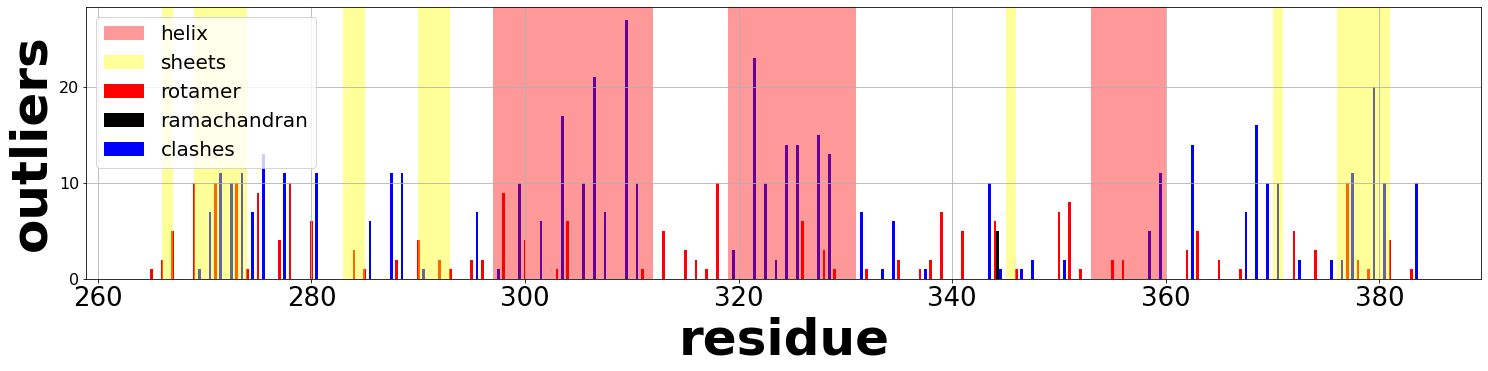

In [2]:
main_program("2n87-assembly1.cif", "2n87_validation.cif")

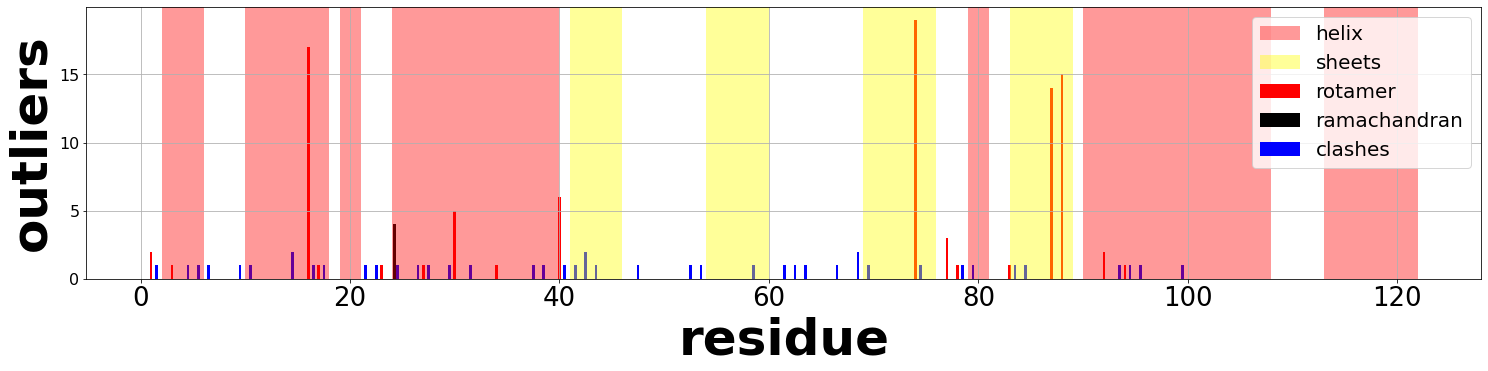

In [3]:
main_program("7n82-assembly1.cif", "7n82_validation.cif")

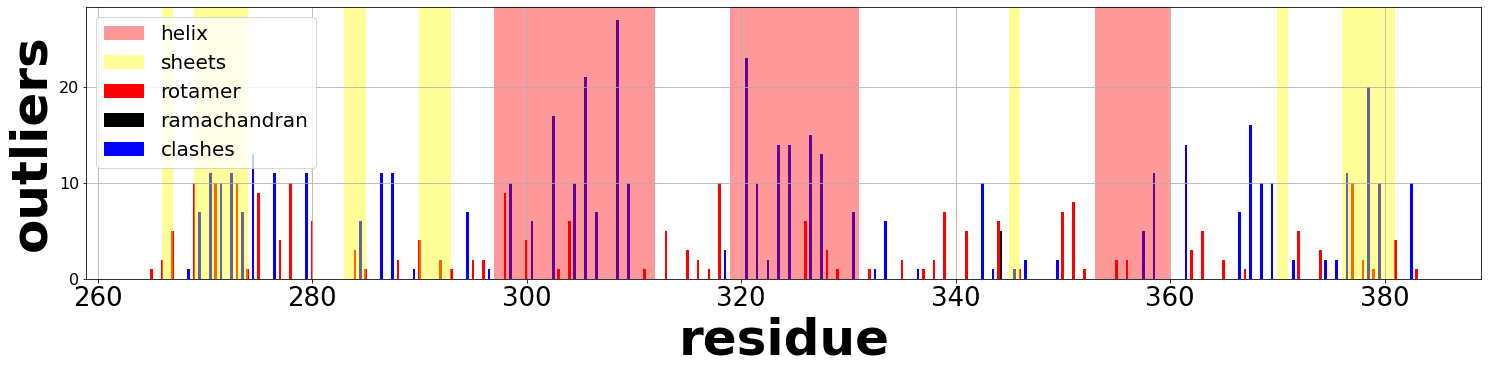

In [4]:
main_program("2n87-assembly1.cif", "2n87_validation.xml.gz.xml")

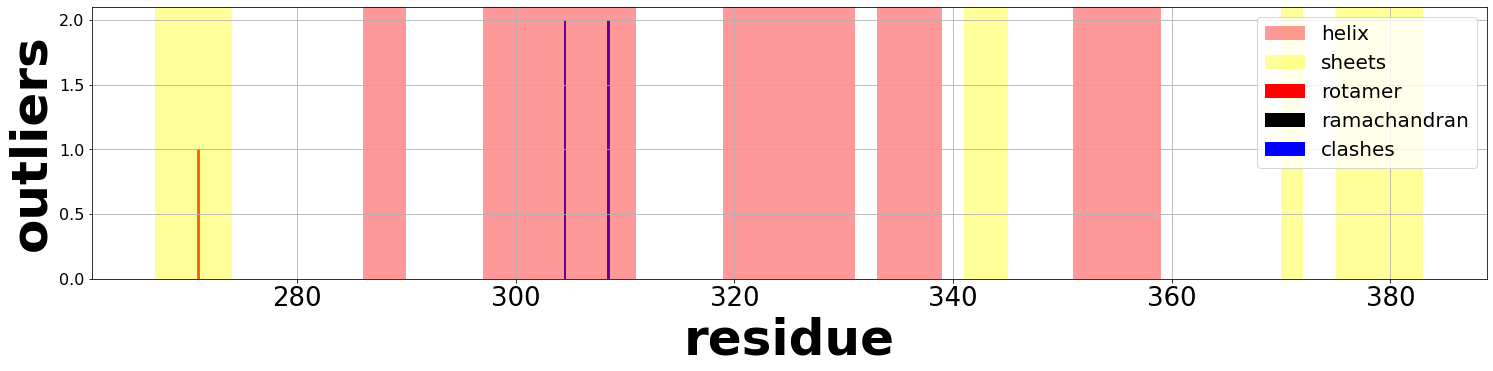

In [5]:
main_program("6gmp-assembly1.cif", "6gmp_validation.xml.gz.xml")

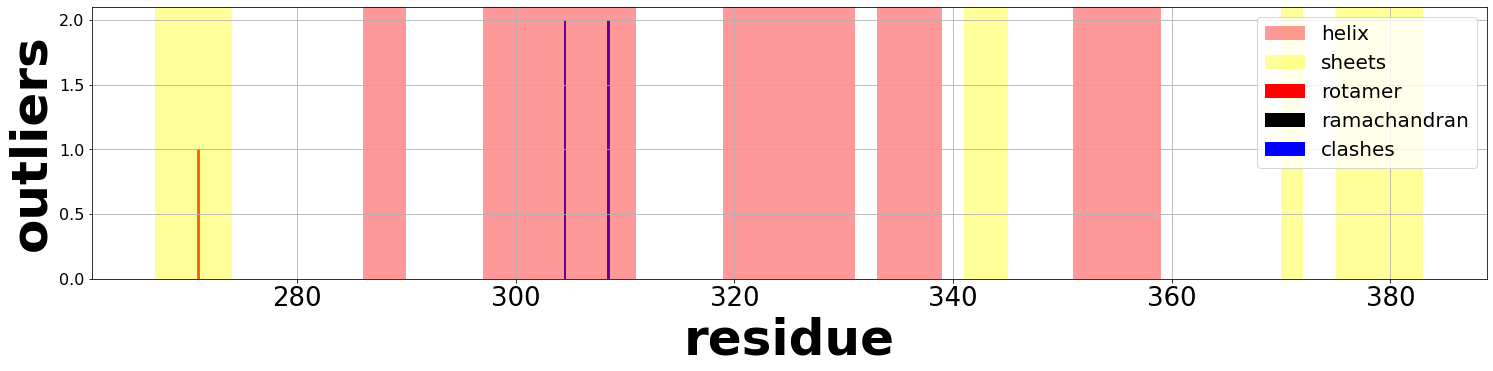

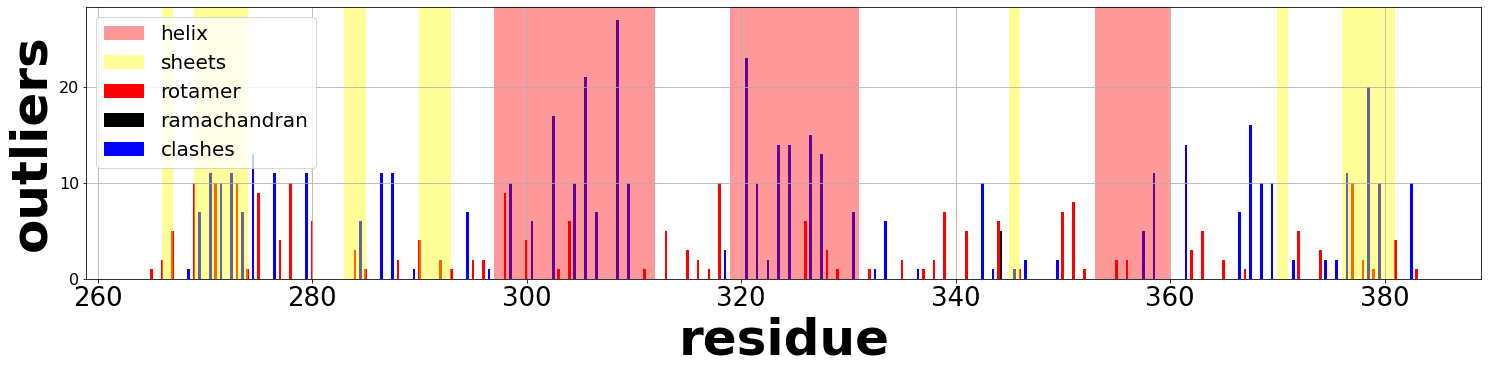

In [6]:
main_program("6gmp-assembly1.cif", "6gmp_validation.xml.gz.xml")
main_program("2n87-assembly1.cif", "2n87_validation.xml.gz.xml")